<a href="https://colab.research.google.com/github/rvanasa/csci-2270-final-project/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instructions

This notebook was designed to run on Google Colaboratory. Please click the link below to view a more streamlined version of the notebook on Google's hosted runtime.

[Open Interactive Notebook](https://colab.research.google.com/github/rvanasa/csci-2270-final-project/blob/master/notebook.ipynb)

If you are currently in Google Colab, consider using the `Runtime -> Run All` menu option to rebuild the entire notebook with newly generated data and visualizations. 

#Purpose

Hash tables are among the most ubiquitous and important data structures in the field of modern software engineering. It is often possible to vastly increase the performance of an algorithm by allocating a fixed-size buffer and reducing the collection's lookup space using a hash function. Hash tables are particularly effective for this use case, and it is therefore helpful to understand the performance benefits and trade-offs for common hash table implementations. 

In particular, we will evaluate the execution time of several hash table implementations against C++ standard library collections, and then analyze the independent performance of each operation, hash function, collision resolution mechanism, and load factor. In doing so, we will gain a more nuanced and quantitative understanding of how to select a hash table implementation for any given application. 

#Procedure

In our analysis, we utilized the following data structures (with element type `U`):

- **Baseline (no hash table)**
  * Balanced binary tree - `std::set<U>`
  * Singly linked list - `SinglyLinkedList<U>::node*`
  * Vector - `std::vector<U>`

- **Linked List Buckets (fixed size `S`)**
  * Array of singly linked lists - `SinglyLinkedList<U>[S]`

- **Balanced Tree Buckets (fixed size `S`)**
  * Array of balanced trees - `BalancedTree<U>[S]`
  * Balanced binary tree - `std::set<U>`

- **Linear Probing**
  * Array pointer of boolean-element pairs - `std::pair<bool, U>*`

- **Cuckoo Hashing (fixed table count `N`)**
  * Array of array pointers of boolean-element pairs - `std::pair<bool, U>*[N]`

Note: *`std::set<U>` is implemented as a balanced binary search tree on all platforms used during evaluation.*

Since we decided to use template parameters to allow any element type (as would be the case in real-world hash table implementations), the linear probing and cuckoo hashing implementations use elements of type `std::pair<bool, U>` to designate element existence at each index. This design feature also provides a slightly more realistic performance evaluation compared to selecting an arbitrary value (such as `-1`) to designate a nonexistent element. 

Another major benefit of template parameters was the ability to "hot-swap" features such as table size, hash function, and element type. Doing so creates a number of compile-time guarantees which would otherwise require highly redundant code, allowing for additional compiler optimizations and memory efficiency in our application. 

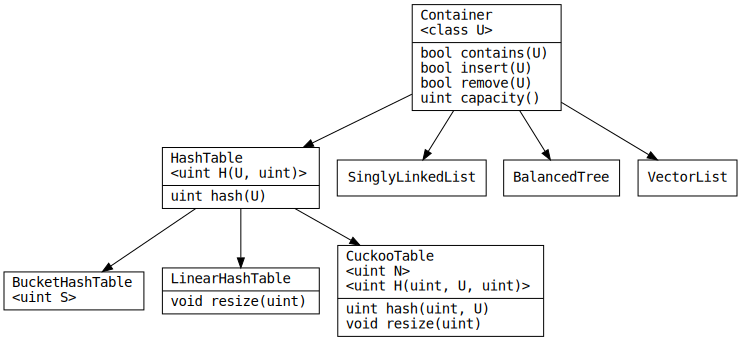

In [1]:
#@title Project architecture and class inheritance

import graphviz as gv

edge_map = {
    'Container': ['SinglyLinkedList', 'BalancedTree', 'VectorList', 'HashTable'],
    'HashTable': ['BucketHashTable', 'LinearHashTable', 'CuckooTable'],
}
props = {
    'Container': [['\<class U\>'], ['bool contains(U)', 'bool insert(U)', 'bool remove(U)', 'uint capacity()']],
    'HashTable': [['\<uint H(U, uint)\>'], ['uint hash(U)']],
    'BucketHashTable': [['\<uint S\>']],
    'LinearHashTable': [[], ['void resize(uint)']],
    'CuckooTable': [['\<uint N\>', '\<uint H(uint, U, uint)\>'], ['uint hash(uint, U)', 'void resize(uint)']],
}

graph = gv.Digraph(
    node_attr=dict(fontname='monospace', shape='record')
)
for n, ps in props.items():
  graph.node(n, label='{'+n+'\l'+'|'.join('\l'.join(p)+'\l' if p else '' for p in ps)+'}')
for k, vs in edge_map.items():
  for v in vs:
    graph.edge(k, v)
graph

The following hash functions are used in our analysis:

- $h_0(x, S) = x \mod{S}$

- $h_1(x, S) = \left\lfloor{\frac{x}{S}}\right\rfloor \mod{S}$

- $h_2(x, S) = x | (3 \ll 10) \mod{S}$

- $h_3(x, S) = x | (3 \ll 8) \mod{S}$

- $H(N, x, S) = h_N(x, S)$

Note: $h_3(x, S)$ *is used solely for 4-table cuckoo hashing.*

In [2]:
#@title Environment configuration

import os
os.chdir('/content')
!rm -rf ./csci-2270-final-project
!git clone https://github.com/rvanasa/csci-2270-final-project
os.chdir('csci-2270-final-project')

Cloning into 'csci-2270-final-project'...
remote: Enumerating objects: 277, done.
remote: Total 277 (delta 0), reused 0 (delta 0), pack-reused 277
Receiving objects: 100% (277/277), 85.26 MiB | 10.60 MiB/s, done.
Resolving deltas: 100% (188/188), done.
Checking out files: 100% (70/70), done.


#Data

In our analysis, we will be using the provided datasets `A` and `C`. Upon investigating the distribution of each dataset, it is apparent that `A` is evenly distributed within the range $(0, 10^8)$, while `C` contains values primarily in the ranges $(1\times10^7, 4\times10^7) \cup (6\times10^7, 8\times10^7)$, resulting a value distribution twice as dense as that of `A`. 

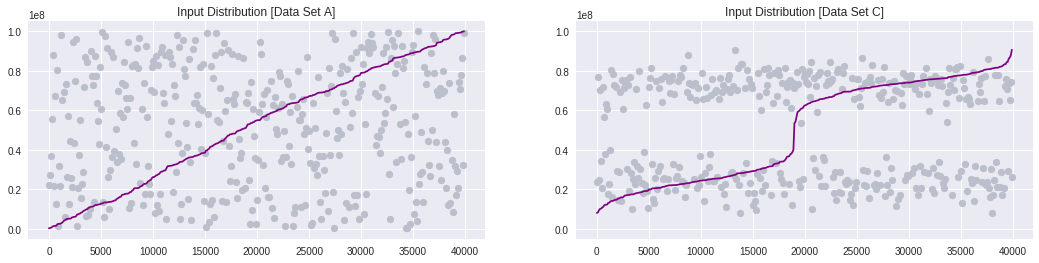

In [5]:
#@title Comparison of dataset distributions

from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

datasets = ['A', 'C']
batch_size = 100

fig, axs = plt.subplots(1, len(datasets), figsize=(18, 4))

for dataset, ax in zip(datasets, axs):
  with open(f'data/dataSet{dataset}.csv') as f:
    numbers = [int(n) for n in f.read().split(',')][::batch_size]
    ax.set_title(f'Input Distribution [Data Set {dataset}]')
    ax.set_ylim(-.05e8, 1.05e8)
    ax.scatter(np.arange(len(numbers)) * batch_size, numbers, color='#BBBFCB')
    ax.plot(np.arange(len(numbers)) * batch_size, sorted(numbers), color='purple')

plt.show()

# Results

In order to obtain the below results, we recorded the precise execution time for each combination of dataset, operation, hash function, collision resolution mechanism, and load factor. 

The test was performed on both Windows 10 Personal Edition and Ubuntu 18.04 LTS. 

In [4]:
#@title Binary executable compilation

%%bash
cmake .
make

-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done
-- Generating done
-- Build files have been written to: /content/csci-2270-final-project
Scanning dependencies of target CSCI_2270
[ 50%] Building CXX object CMakeFiles/CSCI_2270.dir/main.cpp.o
[100%] Linking CXX executable CSCI_2270
[100%] Built target CSCI_2270


In [201]:
#@title Evaluation on Data Set A

%%bash
DATA=dataSetA
mkdir -p output/linux_$DATA
./CSCI_2270 data/$DATA.csv output/linux_$DATA

Loading dataset: data/dataSetA.csv
Finding duplicates to verify correctness...
22181778, 82990386, 90635073, 98384227, 37000771, 49229287
Profiling containers...

[baseline: balanced tree]
* insert: 1010 ns
* contains: 800 ns
* remove: 1096 ns

[baseline: linked list]
* insert: 64 ns
* contains: 135086 ns
* remove: 139940 ns

[baseline: vector]
* insert: 65 ns (resizes: 17)
* contains: 133359 ns
* remove: 1699 ns

[linked list {h(x)}]
* insert: 162 ns
* contains: 117 ns
* remove: 162 ns

[binary tree {h(x)}]
* insert: 611 ns
* contains: 274 ns
* remove: 560 ns

[linear probing {h(x)}]
* insert: 2630 ns (resizes: 4)
* contains: 97 ns
* remove: 219 ns

[linked list {h'(x)}]
* insert: 214 ns
* contains: 157 ns
* remove: 219 ns

[binary tree {h'(x)}]
* insert: 634 ns
* contains: 294 ns
* remove: 699 ns

[linear probing {h'(x)}]
* insert: 306944 ns (resizes: 4)
* contains: 208228 ns
* remove: 220312 ns

[linked list {h*(x)}]
* insert: 182 ns
* contains: 136 ns
* remove: 166 ns

[binary tree

In [202]:
#@title Evaluation on Data Set B

%%bash
DATA=dataSetC
mkdir -p output/linux_$DATA
./CSCI_2270 data/$DATA.csv output/linux_$DATA

Loading dataset: data/dataSetC.csv
Finding duplicates to verify correctness...
25064813, 23551376, 71896529, 26469143, 75165293, 32216745, 27855688, 75150082, 50000000, 78947382, 80767239, 77021379, 26253031, 21802475, 22570933, 70300437, 21608650, 14708836, 25153284, 26184471
Profiling containers...

[baseline: balanced tree]
* insert: 964 ns
* contains: 805 ns
* remove: 1118 ns

[baseline: linked list]
* insert: 71 ns
* contains: 144635 ns
* remove: 149451 ns

[baseline: vector]
* insert: 70 ns (resizes: 17)
* contains: 143266 ns
* remove: 1862 ns

[linked list {h(x)}]
* insert: 199 ns
* contains: 190 ns
* remove: 237 ns

[binary tree {h(x)}]
* insert: 707 ns
* contains: 451 ns
* remove: 812 ns

[linear probing {h(x)}]
* insert: 2343 ns (resizes: 4)
* contains: 124 ns
* remove: 537 ns

[linked list {h'(x)}]
* insert: 266 ns
* contains: 223 ns
* remove: 284 ns

[binary tree {h'(x)}]
* insert: 753 ns
* contains: 481 ns
* remove: 853 ns

[linear probing {h'(x)}]
* insert: 342583 ns (res

In [73]:
#@title Configuration for data visualization

def single_hash_group(prefix):
  return [f'{prefix}_hx', f'{prefix}_h1x', f'{prefix}_h2x']

output_dir = './output'
platforms = ['windows', 'linux']
operations = ['insert', 'contains', 'remove']
batch_smooth = 50
groups = {
    'Baseline': ['baseline_linked_list', 'baseline_balanced_tree', 'baseline_vector'],
    'Linked List Buckets': single_hash_group('linked_list'),
    'Binary Tree Buckets': single_hash_group('binary_tree'),
    'Linear Probing': single_hash_group('linear_probing'),
    'Cuckoo Hashing': ['cuckoo_hashing_3', 'cuckoo_hashing_4'],
}
hashfns = {
    'x': 'h(x)',
    '1x': 'h\'(x)',
    '2x': 'h*(x)',
}

data = []
for platform in platforms:
  for dataset in datasets:
    for group_name, names in groups.items():
      for name in names:
        path = f'{output_dir}/{platform}_dataSet{dataset}/{name}.csv'
        df = pd.read_csv(path)
        df.time = df.time / 1000
        data.append({
            'key': f'{platform}:{dataset}:{name}',
            'platform': platform,
            'dataset': dataset,
            'group': group_name,
            'name': name,
            'df': df,
            **dict((operation, df[df.operation == operation]) for operation in operations),
        })

query = pd.DataFrame(data)
query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 9 columns):
key         56 non-null object
platform    56 non-null object
dataset     56 non-null object
group       56 non-null object
name        56 non-null object
df          56 non-null object
insert      56 non-null object
contains    56 non-null object
remove      56 non-null object
dtypes: object(9)
memory usage: 4.1+ KB


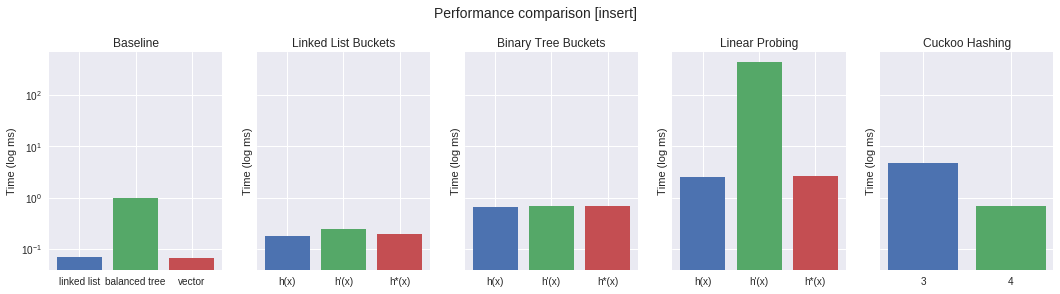

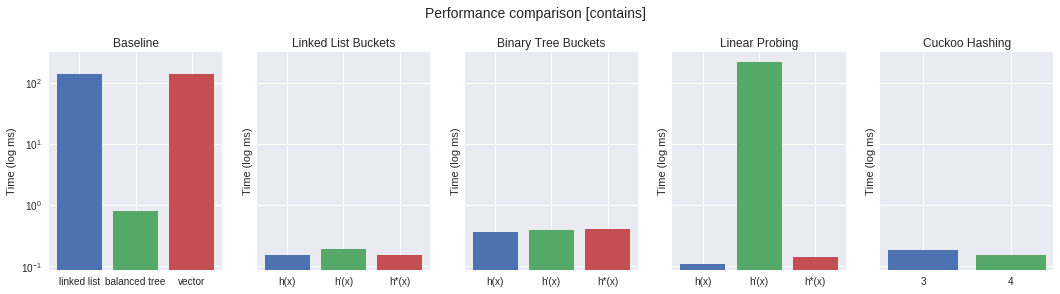

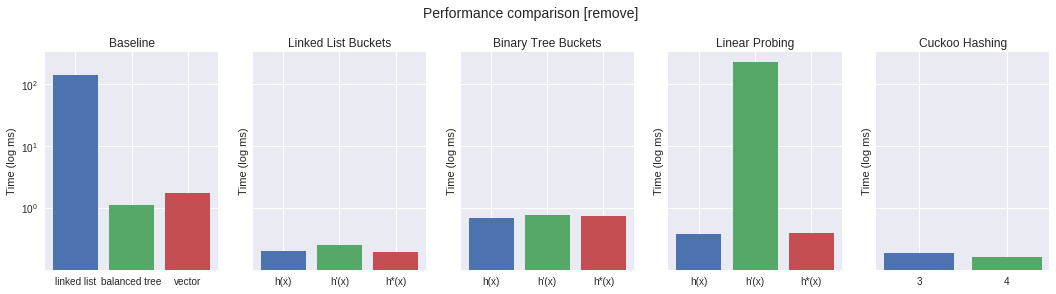

In [14]:
#@title Comparison of operation-wise execution time

for operation in operations:
  fig, axs = plt.subplots(1, len(groups), figsize=(18, 4), sharey=True)
  plt.figtext(.5, 1, f'Performance comparison [{operation}]', fontsize=14, ha='center')

  for (group_name, names), ax in zip(groups.items(), axs):
    index = 0
    while len(set(n[index] for n in names)) == 1:
      index += 1
    for name in names:
      q = query[(query.group == group_name) & (query.platform == platform) & (query.name == name)]
      name = name[index:].replace('_', ' ')
      name = hashfns.get(name, name)

      df = q[operation].sum()
      ax.set_title(group_name)
      ax.set_ylabel('Time (log ms)')
      ax.bar(name, df.time.mean() / len(q[operation]))
      ax.set_yscale('log')

  plt.show()

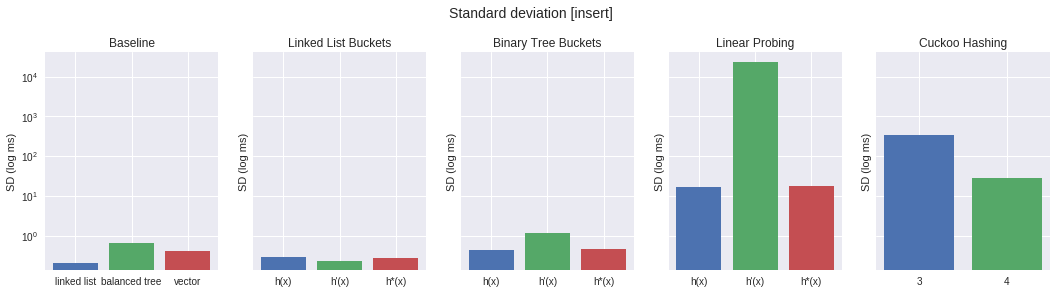

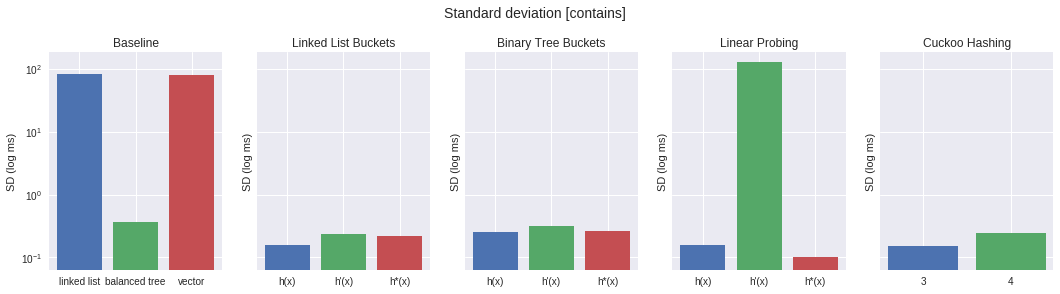

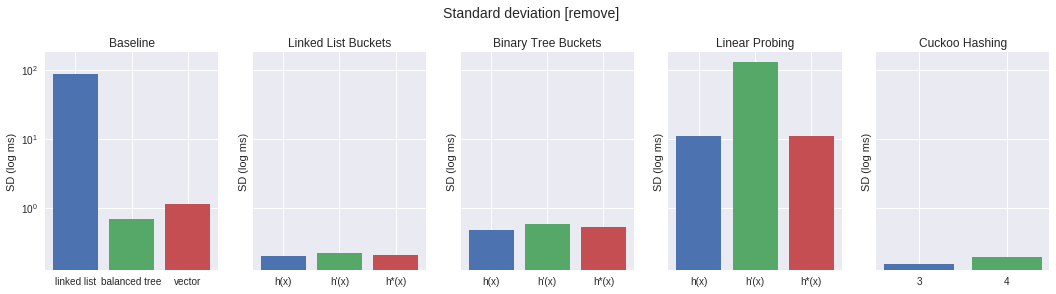

In [15]:
#@title Comparison of operation-wise standard deviations

for operation in operations:
  fig, axs = plt.subplots(1, len(groups), figsize=(18, 4), sharey=True)
  plt.figtext(.5, 1, f'Standard deviation [{operation}]', fontsize=14, ha='center')

  for (group_name, names), ax in zip(groups.items(), axs):
    index = 0
    while len(set(n[index] for n in names)) == 1:
      index += 1
    for name in names:
      q = query[(query.group == group_name) & (query.platform == platform) & (query.name == name)]
      name = name[index:].replace('_', ' ')
      name = hashfns.get(name, name)

      df = q[operation].sum()
      ax.set_title(group_name)
      ax.set_ylabel('SD (log ms)')
      ax.bar(name, df.time.std() / len(q[operation]))
      ax.set_yscale('log')

  plt.show()

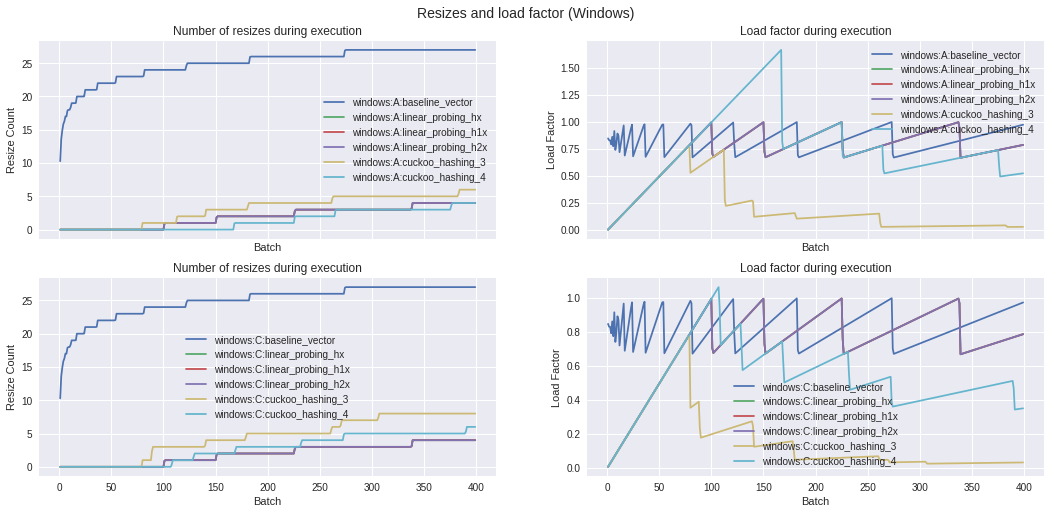

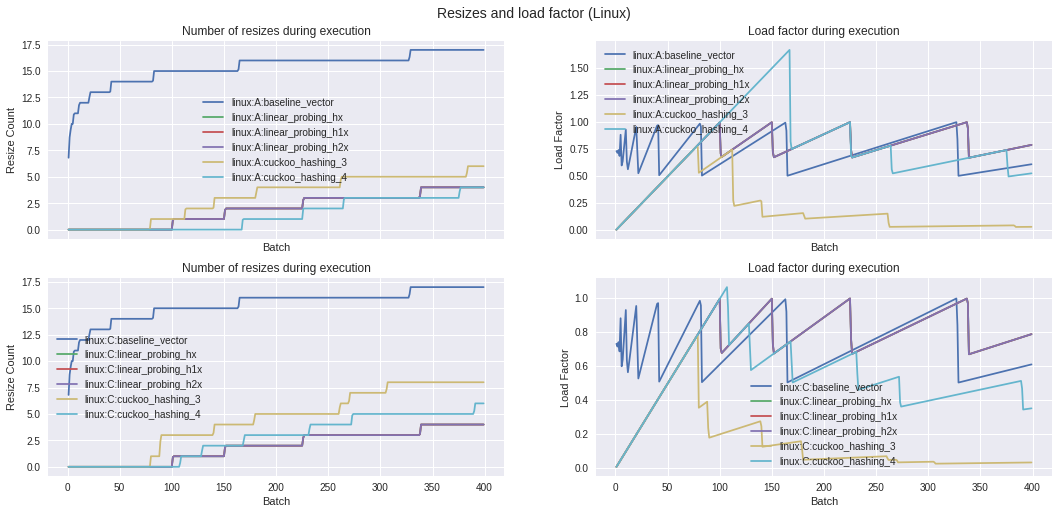

In [16]:
#@title Comparison of resize counts and load factor

for platform in platforms:
  fig, axss = plt.subplots(len(datasets), 2, figsize=(18, 8), sharex=True)
  plt.figtext(.5, .92, f'Resizes and load factor ({platform.capitalize()})', fontsize=14, ha='center')
  for dataset, axs in zip(datasets, axss):
    qq = query[(query.platform == platform) & (query.dataset == dataset)]

    ax = axs[0]
    for _, q in qq.iterrows():
      df = q['insert'].rolling(batch_size).mean()[::batch_size]
      if any(df.resize_count > 0):
        ax.plot(np.arange(len(df.index)), df.resize_count, label=q.key)
    ax.set_title('Number of resizes during execution')
    ax.set_xlabel('Batch')
    ax.set_ylabel('Resize Count')
    ax.legend(fancybox=True, framealpha=.75)

    ax = axs[1]
    for _, q in qq.iterrows():
      df = q['insert'].rolling(batch_size).mean()[::batch_size]
      if any(df.resize_count > 0):
        ax.plot(np.arange(len(df.index)), df.load_factor, label=q.key)
    ax.set_title('Load factor during execution')
    ax.set_xlabel('Batch')
    ax.set_ylabel('Load Factor')
    ax.legend(fancybox=True, framealpha=.75)

plt.show()

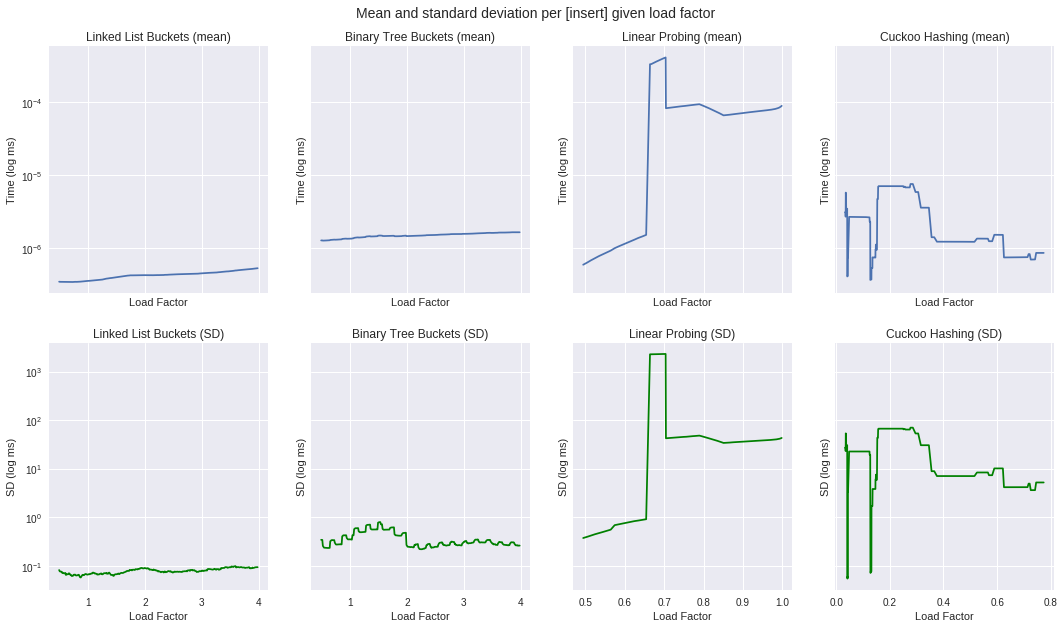

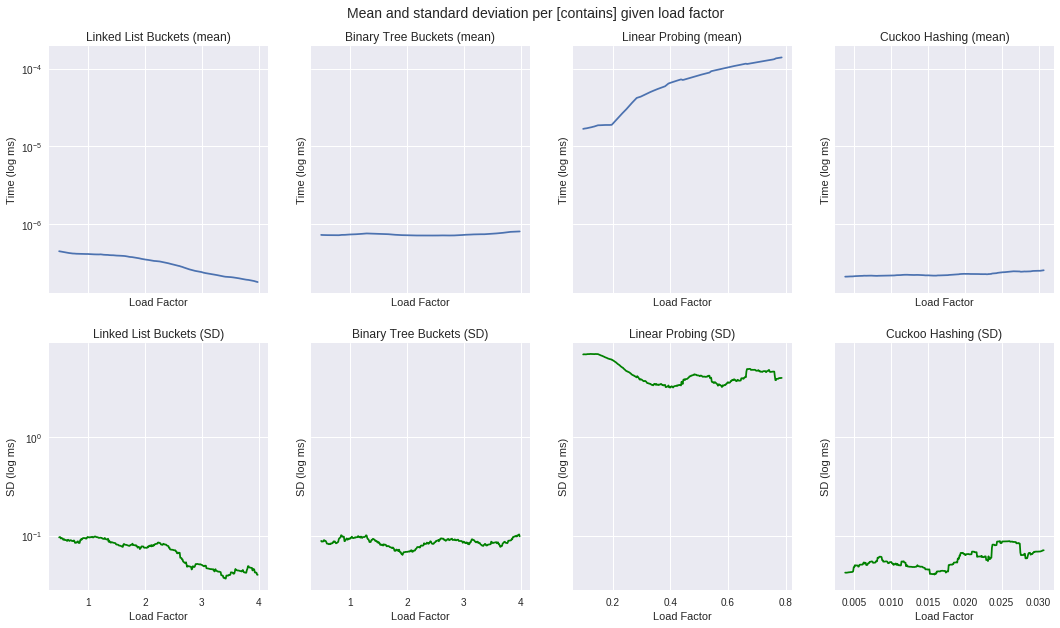

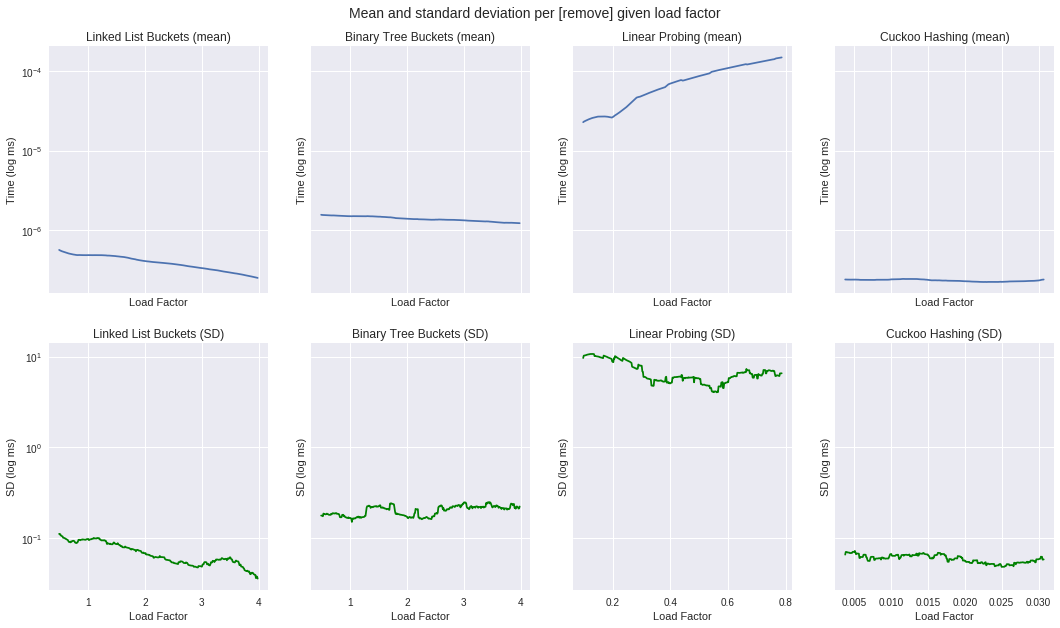

In [28]:
#@title Performance comparison across load factors

for operation in operations:
  lf_groups = [g for g in groups if g != 'Baseline']

  fig, axss = plt.subplots(2, len(lf_groups), figsize=(18, 10), sharex='col', sharey='row')
  plt.figtext(.5, .92, f'Mean and standard deviation per [{operation}] given load factor', fontsize=14, ha='center')

  for group_name, axs in zip(lf_groups, zip(*axss)):
    dfs = [df.sort_values(by='load_factor') for df in query.groupby('group').get_group(group_name)[operation]]
    
    time = np.zeros(len(dfs[0].index))
    for df in dfs:
      time += df.time / len(dfs)
    
    load_factor = dfs[0].rolling(batch_size).mean()[::batch_size].load_factor
    stdev = time.rolling(batch_size).std()[::batch_size]
    time = time.rolling(batch_size).mean()[::batch_size]

    ax = axs[0]
    ax.set_title(f'{group_name} (mean)')
    ax.set_xlabel('Load Factor')
    ax.set_ylabel('Time (log ms)')
    ax.set_yscale('log')
    ax.plot(load_factor, time.rolling(batch_smooth).mean() / 1e6)

    ax = axs[1]
    ax.set_title(f'{group_name} (SD)')
    ax.set_xlabel('Load Factor')
    ax.set_ylabel('SD (log ms)')
    ax.set_yscale('log')
    ax.plot(load_factor, stdev.rolling(batch_smooth).mean(), color='g')

  plt.show()

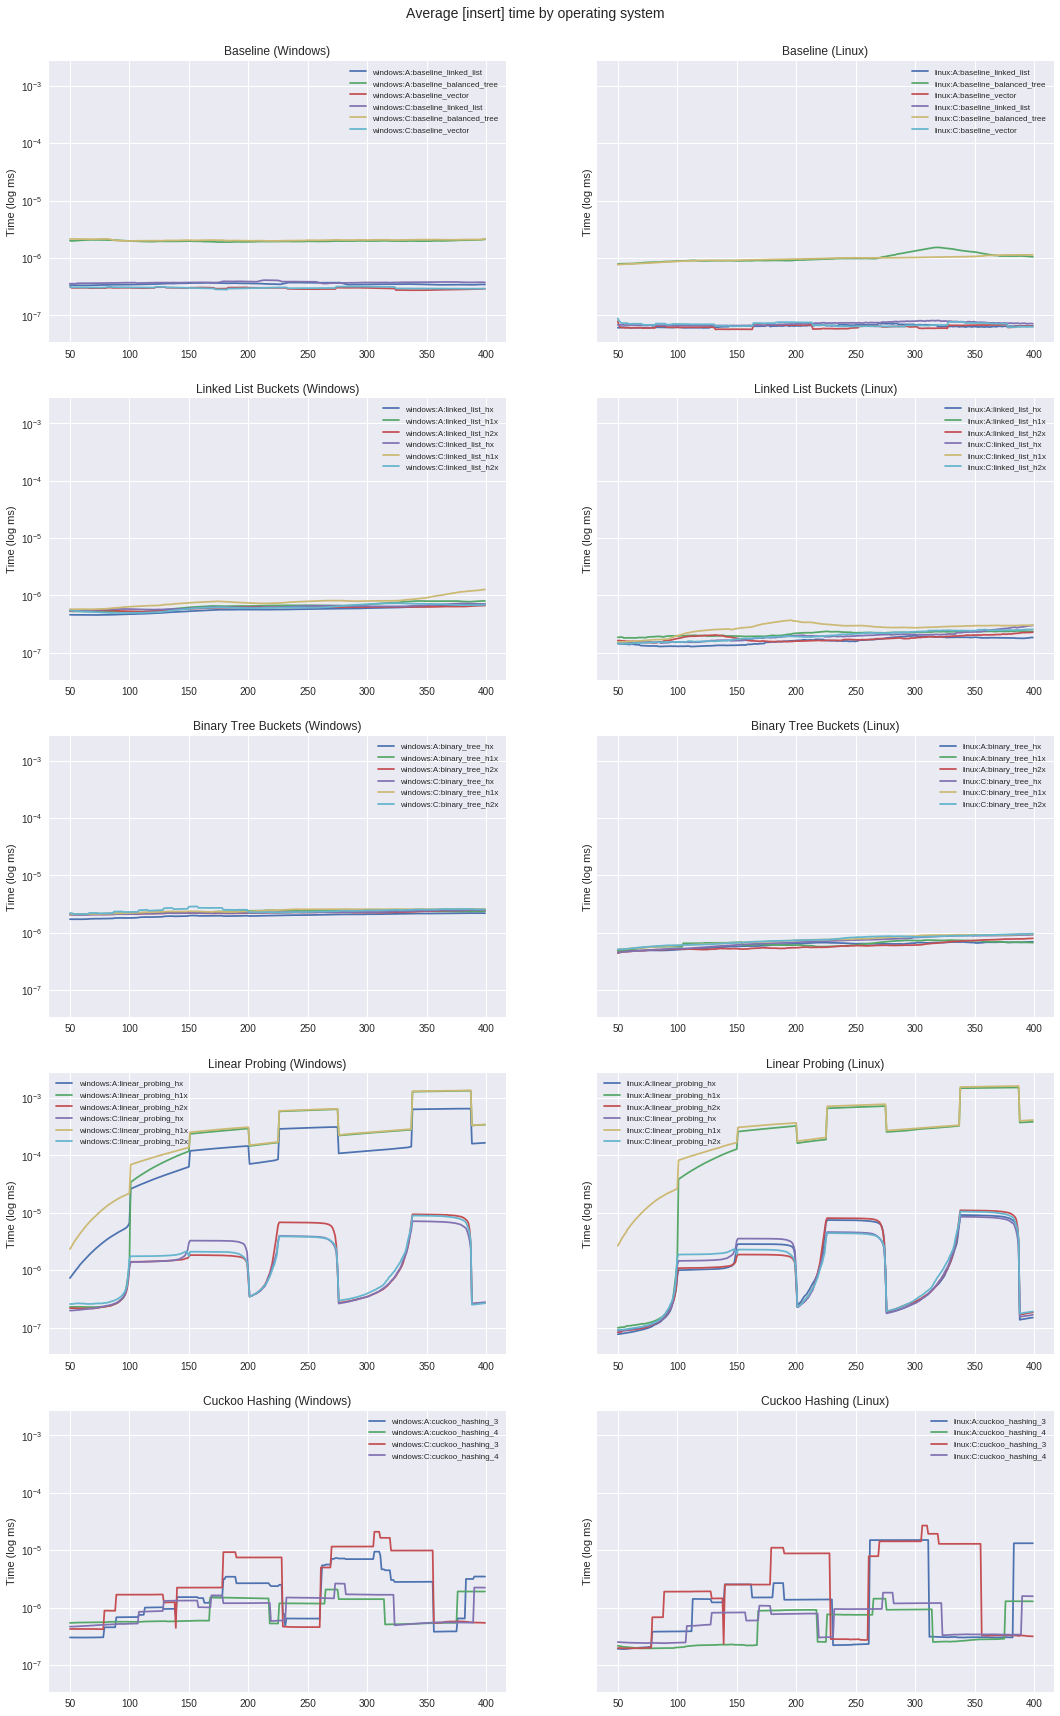

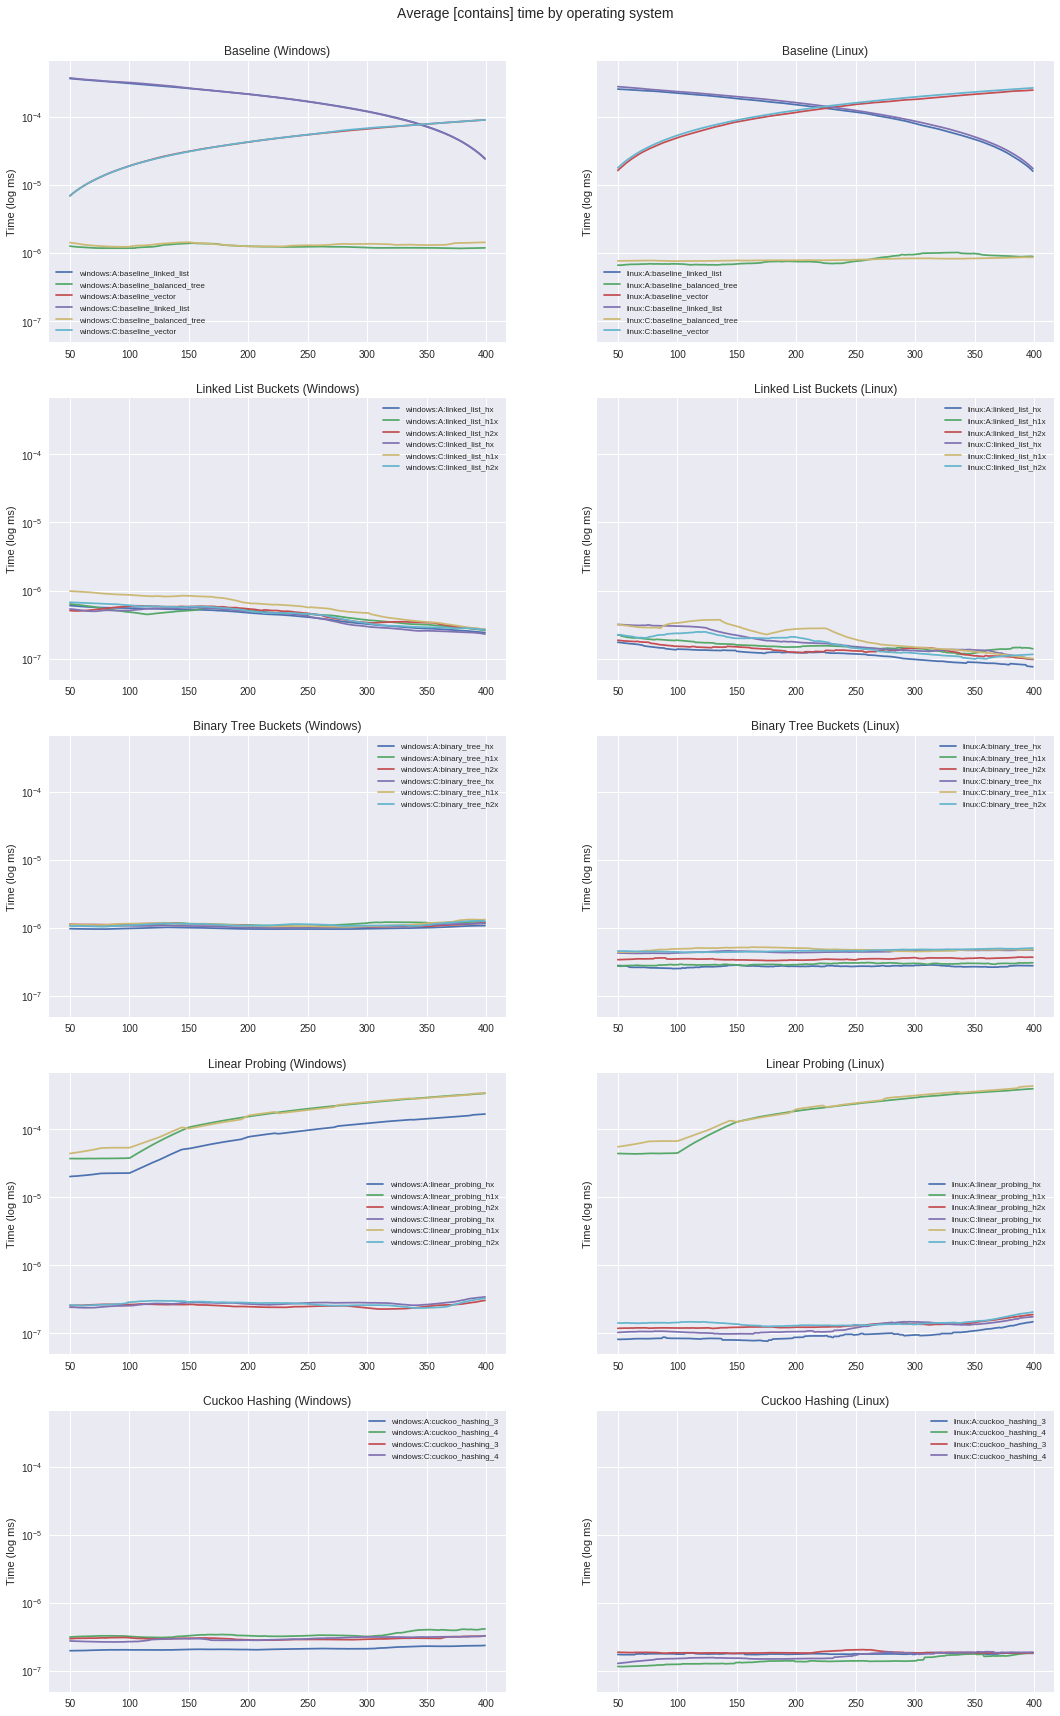

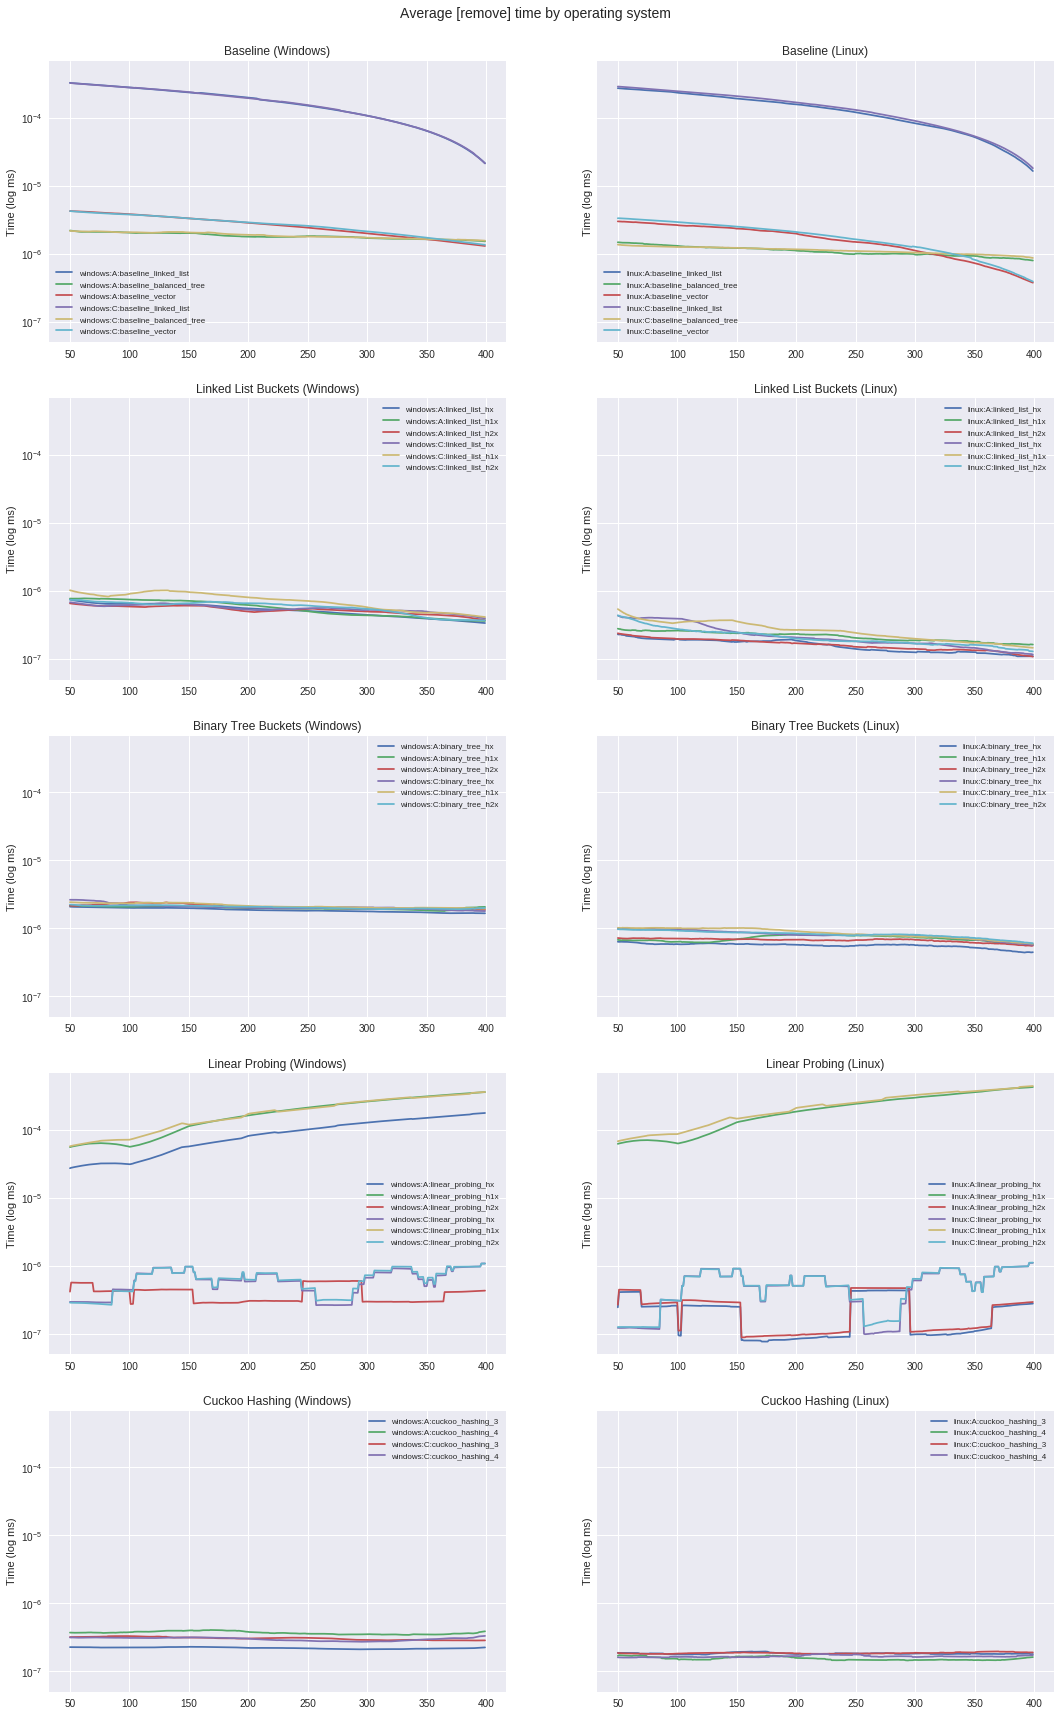

In [30]:
#@title Performance comparison between platforms

for operation in operations:
  fig, axss = plt.subplots(len(groups), len(platforms), figsize=(18, 30), sharey=True)
  plt.figtext(.5, .9, f'Average [{operation}] time by operating system', fontsize=14, ha='center')

  for group_name, axs in zip(groups, axss):
    for platform, ax in zip(platforms, axs):
      for _, q in query[(query.group == group_name) & (query.platform == platform)].iterrows():
        df = q[operation].rolling(batch_size).mean()[::batch_size]
        ax.set_title(f'{group_name} ({platform.capitalize()})')
        ax.set_ylabel('Time (log ms)')
        ax.set_yscale('log')
        ax.plot(np.arange(len(df.index)), df.time.rolling(batch_smooth).mean() / 1e6, label=q.key)
        ax.legend(fontsize=8, fancybox=True, framealpha=.75)
  
  plt.show()

In [49]:
#@title Average performance per implementation

for operation in operations:
  data = []
  for group_name in groups:
    q = query.groupby('group').get_group(group_name)
    dfs = list(df.rolling(batch_size).mean()[::batch_size] for df in q[operation])
    index_len = len(dfs[0].index)
    resize_count = np.zeros(index_len, dtype=float)
    time = np.zeros(index_len, dtype=float)
    stdev = 0
    for df in dfs:
      resize_count += df.resize_count / len(dfs)
      time += df.time / len(dfs)
      stdev += df.time.std() / len(dfs)
    
    data.append({
        'Operation': operation,
        'Time (ms)': round(time.mean(), 1),
        'SD (ms)': round(time.std(), 2),
        'Resizes': round(resize_count.mean(), 1),
        'Score (1/ms)': round(1 / time.mean(), 1),
    })

  display(pd.DataFrame(data, index=groups))

,Operation,Time (ms),SD (ms),Resizes,Score (1/ms)
Baseline,insert,0.6,0.05,6.7,1.6
Linked List Buckets,insert,0.4,0.06,0.0,2.4
Binary Tree Buckets,insert,1.5,0.17,0.0,0.7
Linear Probing,insert,150.4,1125.32,2.0,0.0
Cuckoo Hashing,insert,2.4,13.62,2.9,0.4


,Operation,Time (ms),SD (ms),Resizes,Score (1/ms)
Baseline,contains,87.3,14.97,0.0,0.0
Linked List Buckets,contains,0.3,0.10,0.0,3.1
Binary Tree Buckets,contains,0.7,0.03,0.0,1.3
Linear Probing,contains,72.8,43.00,0.0,0.0
Cuckoo Hashing,contains,0.2,0.02,0.0,4.4


,Operation,Time (ms),SD (ms),Resizes,Score (1/ms)
Baseline,remove,54.1,31.36,0.0,0.0
Linked List Buckets,remove,0.4,0.10,0.0,2.5
Binary Tree Buckets,remove,1.4,0.12,0.0,0.7
Linear Probing,remove,78.3,43.42,0.0,0.0
Cuckoo Hashing,remove,0.2,0.01,0.0,4.2


#Conclusion

Upon reviewing the above results, it is clear that each implementation carries a different set of strengths and weaknesses. 

- **Linked List Buckets**
  * Performed best for `insert`, and held up surprisingly well for `contains` and `remove`. 
  * Decent "all-rounder" implementation for applications requiring an unpredictable mix of insertions, lookups, and deletions. 

- **Balanced Tree Buckets**
  * Performed well on `insert`, `contains`, and `remove`, although was generally inferior to using a linked list. 

- **Linear Probing**
  * Performed well on `contains` (and `insert` to a lesser extent) when provided a relatively well-distributed hash function, and performed horribly in all other situations. 
  * Ideal for use cases requiring highly available, generally unchanging data. Choosing an appropriate hash function is critical for this implementation to be efficient. 
  * Execution time is highly consistent between operating systems. 

- **Cuckoo Hashing**
  * Unpredictable `insert` times but hilariously fast `contains` and `remove` operations. Increasing the number of tables improved the insertion time but negatively affected the other two operations. 
  * Slower than linear probing at low load factors but faster at high load factors, particularly for `contains` and `remove`. 
  * Execution time is highly consistent between operating systems. 
  * Best aggregate performance in all three operations, although this implementation may be undesirable in some situations due to having relatively unpredictable insertion time. 

Performance was generally similar between Windows and Linux, although Windows tended to have unexpectedly different execution times for $h(x)$ compared to other hash functions. It is possible that in these cases, Windows may be using different optimizations and more aggressive caching strategies for modular arithmetic. 


In [48]:
#@title Implementation scores per operation

data = {
    'insert': [],
    'contains': [],
    'remove': [],
    'df': [],
}
for operation in operations + ['df']:
  for group_name in groups:
    q = query.groupby('group').get_group(group_name)
    dfs = list(df.rolling(batch_size).mean()[::batch_size] for df in q[operation])
    index_len = len(dfs[0].index)
    time = np.zeros(index_len, dtype=float)
    for df in dfs:
      time += df.time / len(dfs)

    data[operation].append(round((1 / time).mean(), 1))

display(pd.DataFrame({
    'Insert': data['insert'],
    'Contains': data['contains'],
    'Remove': data['remove'],
    'Overall': data['df'],
}, index=groups))

,Insert,Contains,Remove,Overall
Baseline,1.6,0.0,0.0,0.5
Linked List Buckets,2.4,3.5,2.7,2.8
Binary Tree Buckets,0.7,1.4,0.7,0.9
Linear Probing,0.6,0.0,0.0,0.2
Cuckoo Hashing,2.6,4.4,4.2,3.6
